# Python Learn by Doing: Climate Change Indicators

Developed By: Dr. Kerrie Geil, Mississippi State University

Date: January 2024

Requirements: list space, RAM, and pacakge requirements

Link: notebook available to download at 

<u> Description </u>

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around obtaining climate data, computing climate change indices, and determining the statistical significance of change. The notebook is aimed at learners who already have some knowledge of programming and statistics. 

<u> Summary of Contents </u>

put an outline of tasks/skills here

-----

# Introduction to Climate Change Indicators

Put a description of what they are

Include a bunch of links

Spell out which ones we will be computing

Selection of ETCCDI Climate Extremes Indices
- Monthly Maximum Value of Daily Minimum Temperature (TNx)
- Growing Season Length (GSL)
- Warm Spell Duration Index (WSDI)
- Monthly Maximum Consecutive 5-day Precipitation (Rx5day)
- Maximum Length of Consecutive Dry Days (CDD)
- Annual Total Precip Amount Over 99th Percentile of Wet Days (R99pTOT)

**Disclaimer:** This notebook is intended for python programming learning only. The data quality checking and calculation of ETCCDI climate change indices in this notebook may differ from the ETCCDI published instructions for simplicity and/or relevance to our learning goals. Learners wanting to compute the indices according to the exact ETCCDI instructions (which would be required for example for use in a scientific publication) should consult the [documentation](https://etccdi.pacificclimate.org/index.shtml). The documentation suggests using the [RClimDex software package](https://github.com/ECCC-CDAS/RClimDex.git) written in R to calculate ETCCDI climate change indices. Another option would be to use pre-calculated indices based on multiple gridded datasets available at [climdex.org](https://www.climdex.org/), which also offers a similar software package for calculating the indices on a dataset of your choice.   


For the climate change indices covered in this notebook we will need the following observational data over many data years:

variable abbrev. | description | frequency | units
---|---|---|---
tmin | minimum surface air temperature | daily | C 
tmax | maximum surface air temperature | daily | C
prcp | accummulated precipitation | daily | mm/day

# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import os
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
import pandas as pd

import numpy.testing as npt
import warnings

import matplotlib.pyplot as plt
# import gzip
# import shutil

# import pandas as pd

In [2]:
# learners need to update these paths to reflect locations on their own computer/workspace

# path to your working directory (where this notebook is on your computer)
# work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/climate_change_indicators/' 
work_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/climate_change_indicators/' 

# path to where you'll download and store the data files
# data_dir = r'C://Users/kerrie/Documents/02_LocalData/tutorials/AgERA5_daily/'
data_dir=r'C://Users/kerrie.WIN/Documents/data/AgERA5/'

# path to write output files and figures
# output_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/climate_change_indicators/outputs/'
output_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/climate_change_indicators/outputs/'


# create directories if they don't exist already
# if not os.path.exists(work_dir):
#     os.makedirs(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Obtaining the Data

We will use the AgERA5 gridded dataset in this notebook, obtained from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=overview). Data file are temporarily available during the workshop at [John website here](). These files have been minimally pre-processed to save time during the workshop. We will download them together in subsequent notebook cells. 

The pre-processing steps that have been completed for you include:
1) Using the Climate Data Store (CDS) API to download AgERA5 precipitation and 2m min and max temperature. You need a free CDS account and to install the cdsapi python package as well as python dask to do this. The data downloads as one .tar.gz file per year per variable.
2) Unpacking the .tar.gz files. Each zipped archive unpacks to one netcdf file per day per variable (many files).
3) Converting temperature units from K to C
4) Converting longitude coordinates from 0 to 360 to -180 to 180
5) Consolidating all the daily files into one single netcdf file per variable that contains all times.

We won't cover this process here but there I provide the python scripts that document this process, if you are interested. Step 1-2 is performed in [get_AgERA5_daily_parallel.py]() and steps 3-5 are performed in [prep_AgERA5_daily.ipynb]().



Describe the data requirements (importance of time dimension standardization and missing data) 

Warnings against performing climate change analyses on just any dataset (example PRISM)

Warnings about high resolution spatial data (much of it is interpolated, high res not always better)

Why we choose to use certain datasets

Links to each dataset's webpage

In [3]:
# urls = ['https://www.url-to-johns-data-page',
#         'https://www.url-to-johns-data-page',
#         'https://www.url-to-johns-data-page']

# filenames = [data_dir+'prcp_AgERA5_Mississippi_Daily_1979-2023.nc',
#             data_dir+'tmax_AgERA5_Mississippi_Daily_1979-2023.nc',
#             data_dir+'tmin_AgERA5_Mississippi_Daily_1979-2023.nc']

filenames = [data_dir+'prcp_AgERA5_Starkville_Daily_1979-2023.nc',
            data_dir+'tmax_AgERA5_Starkville_Daily_1979-2023.nc',
            data_dir+'tmin_AgERA5_Starkville_Daily_1979-2023.nc']

# for url,f in zip(urls,filenames):
#     urlretrieve(url, f)

# Introduction to python xarray data structures

In [209]:
pr = xr.open_dataarray(filenames[0])
tx = xr.open_dataarray(filenames[1])
tn = xr.open_dataarray(filenames[2])
pr

<xarray.DataArray 'prcp' (time: 16436, lat: 1, lon: 1)>
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 -88.8
  * lat      (lat) float64 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [210]:
pr=pr.squeeze()
tx=tx.squeeze()
tn=tn.squeeze()
pr

<xarray.DataArray 'prcp' (time: 16436)>
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 -88.8
    lat      float64 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

# Data Cleaning

### ETCCDI suggested data cleaning / quality control

The minimum quality control procedures suggested by ETCCDI are as follows.

Replace data value with Nan for:
- user-defined missing values (i.e -9999-->Nan)
- daily precip values less than 0
- daily max temperature less than daily minimum temperature
- daily temperature greater than 70C (158F) or less than -70C (-94F)
- leap days (i.e Feb 29th)
- impossible dates (i.e. 32nd March, 12th June 2042)
- non-numeric values
- daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)


Addressing each of these items below...

#### nan for user-defined missing values (i.e -9999-->Nan)

xr.open_dataset does this for you. 


Notice in the variable attributes above there is no _FillValue=-9999., which the value stored for missing data in the netcdf. This is because xarray automatically replaces the _FillValue with nan.

#### nan for daily precip values less than 0

In [211]:
# are there any negatives?
(pr<0).data.sum()

0

#### nan for daily max temperature less than daily minimum temperature

In [7]:
# is tx ever less than tn?
(tx<tn).data.sum()

0

In [8]:
# # where tx<tn fill both tx and tn with nan
# tx=xr.where(tx<tn,np.nan,tx)
# tn=xr.where(tx<tn,np.nan,tn)

In [9]:
# # is tx ever less than tn now?
# (tn>tx).data.sum()

#### nan for daily temperature greater than 70C (158F) or less than -70C (-94F)

In [10]:
# is tx>70C, tx<-70C, tn>70C, or tn<-70C?
((tx>70)|(tx<-70)).data.sum(), ((tn>70)|(tn<-70)).data.sum()

(0, 0)

#### leap days (i.e Feb 29th)

here we'll just drop the leap days from the data arrays rather than filling with nan


In [212]:
# first let's double check that the time dimension is the same for 
# all of our data arrays
assert list(pr.time.data)==list(tx.time.data), 'pr.time and tx.time are not equal'
assert list(pr.time.data)==list(tn.time.data), 'pr.time and tn.time are not equal'

# another way to do the same thing without having to convert data structure is with numpy.testing
npt.assert_array_equal(pr.time,tx.time,'pr.time and tx.time are not equal')
npt.assert_array_equal(pr.time,tn.time,'pr.time and tn.time are not equal')

In [12]:
# # find all the leap days
# leapdays=pr.time[(pr.time.dt.day==29) & (pr.time.dt.month==2)]
# leapdays

In [213]:
# find the indexes to all the leap days
leap_ind=np.where((pr.time.dt.day==29) & (pr.time.dt.month==2))[0]
leap_ind

array([  424,  1885,  3346,  4807,  6268,  7729,  9190, 10651, 12112,
       13573, 15034], dtype=int64)

In [214]:
# # drop the leap days from the data arrays
# pr=pr.drop_sel(time=leapdays)
# tx=tx.drop_sel(time=leapdays)
# tn=tn.drop_sel(time=leapdays)
# len(pr)

# fill with nan
# pr=pr.where((pr.time.dt.day==29) & (pr.time.dt.month==2),np.nan,pr)
pr[leap_ind]=np.nan
tx[leap_ind]=np.nan
tn[leap_ind]=np.nan
pr[leap_ind]


<xarray.DataArray 'prcp' (time: 11)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-02-29 1984-02-29 ... 2020-02-29
    lon      float64 -88.8
    lat      float64 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

#### nan for impossible dates (i.e. 32nd March, 12th June 2042)

This data has datetimes for the time dimension. If there were impossible dates, xarray would have had a problem at the open_dataarray statement. So we know there are no impossible dates present.

There could be dates missing, but we can check that just by looking at the length of the time dimension. We have 45 years of daily data, now without leap days. 45years * 365days = 16425days

In [215]:
pr.shape, tx.shape, tn.shape

((16436,), (16436,), (16436,))

#### nan for non-numeric values

Similarly, use of netcdf and xarray ensures that there are no non-numeric values. Each variable in the data file is of one data type (e.g. float) and if there were a non-float value present there would have been an error already. We can be assured the data we've read is all float

In [216]:
pr.dtype, tx.dtype, tn.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

#### daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)

In [17]:
# find the time-mean for each day of the year
tx_daily_mean=tx.groupby(tx.time.dt.dayofyear).mean('time')
tn_daily_mean=tn.groupby(tn.time.dt.dayofyear).mean('time')
tx_daily_mean

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([12.027081 , 11.174386 , 10.803903 , 11.320382 , 10.836358 ,
       11.425187 , 11.025986 ,  9.864721 , 11.071616 , 11.51086  ,
       11.608634 , 11.548942 , 11.401392 , 11.122094 , 10.739694 ,
       10.35078  , 11.1303835, 11.558452 , 11.242924 , 11.08072  ,
       10.672821 , 11.131642 , 11.279192 , 11.779646 , 12.1889515,
       11.489396 , 11.689088 , 12.414181 , 13.118842 , 12.643406 ,
       12.771896 , 13.309137 , 12.180143 , 12.288467 , 11.421821 ,
       10.662051 , 10.94072  , 12.06679  , 12.537083 , 12.640149 ,
       12.833442 , 12.591817 , 11.840858 , 12.377433 , 14.621244 ,
       15.130396 , 14.9814415, 13.482444 , 13.968576 , 14.8303385,
       16.52429  , 17.147501 , 16.246548 , 16.989143 , 16.147106 ,
       14.639749 , 14.669392 , 15.244824 , 16.262869 , 15.323255 ,
       15.852712 , 15.4967   , 16.59131  , 16.880787 , 16.87627  ,
       17.278065 , 17.345232 , 18.074356 , 17.305374 , 17.57616  ,
       17.441267 , 17.727705 , 17.773151 , 18.327677 , 18.361238 ,
       19.167418 , 20.208296 , 19.280214 , 18.7919   , 18.01951  ,
       18.259987 , 19.32307  , 19.99724  , 19.989098 , 19.455114 ,
       20.474897 , 20.608715 , 21.309717 , 20.664413 , 20.11337  ,
       20.702753 , 21.367228 , 21.605482 , 21.158579 , 21.325148 ,
       20.561422 , 20.722368 , 21.037933 , 21.412563 , 22.376463 ,
...
       27.653687 , 26.752954 , 26.649408 , 26.627428 , 26.600039 ,
       26.50467  , 26.438202 , 26.915495 , 26.320295 , 24.832294 ,
       25.224905 , 25.008821 , 24.546854 , 24.206827 , 24.395193 ,
       24.31563  , 24.113235 , 24.529682 , 23.529957 , 23.403055 ,
       23.169207 , 22.676855 , 22.53678  , 23.253733 , 22.657055 ,
       22.339605 , 21.945692 , 21.082008 , 21.544975 , 21.679018 ,
       21.380919 , 21.540422 , 21.757364 , 21.323446 , 20.519712 ,
       20.271208 , 19.55089  , 19.792515 , 19.616985 , 18.83642  ,
       18.677622 , 19.433094 , 19.403004 , 18.995108 , 18.811253 ,
       17.174995 , 16.451162 , 16.789192 , 17.392454 , 17.0696   ,
       16.91106  , 17.189281 , 17.085512 , 16.848625 , 16.92479  ,
       15.973209 , 15.926468 , 15.470793 , 16.358421 , 16.613333 ,
       16.432957 , 15.563018 , 14.518769 , 15.528674 , 15.196157 ,
       14.985846 , 15.071183 , 14.53398  , 14.100435 , 12.958081 ,
       12.909787 , 13.484516 , 14.366299 , 13.777286 , 13.386744 ,
       12.568279 , 12.851055 , 13.313987 , 13.371717 , 13.168545 ,
       12.559139 , 11.684538 , 11.836232 , 11.845224 , 12.807165 ,
       13.372236 , 11.71492  , 10.958113 , 11.034016 , 10.606393 ,
       12.615095 , 12.875556 , 12.445377 , 12.199896 , 12.656247 ,
       14.586374 ], dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [18]:
# find the standard deviation for each day of the yar
# .std throws a runtime warning about degrees of freedom because of 
# nan in the data so we supress the warnings here

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
    tx_stddev=tx.groupby(tx.time.dt.dayofyear).std('time')
    tn_stddev=tn.groupby(tn.time.dt.dayofyear).std('time')
tx_stddev

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([5.4912786, 6.216916 , 6.7524047, 6.305629 , 4.9125943, 5.619153 ,
       6.193696 , 6.1184273, 5.370817 , 6.001833 , 6.3976464, 6.3937063,
       5.704127 , 5.1726866, 4.653944 , 5.4454875, 5.9743557, 5.412213 ,
       5.64786  , 6.1651807, 6.097004 , 4.659649 , 5.2527986, 4.619986 ,
       4.8716145, 4.9906917, 4.4617677, 4.9259896, 5.476677 , 4.798872 ,
       4.993502 , 6.1828604, 6.5739326, 6.143897 , 5.5068216, 5.44991  ,
       6.2139606, 5.8218255, 5.7252374, 5.5949054, 5.7201066, 5.6797523,
       5.946364 , 5.058682 , 4.824379 , 6.0953703, 5.1641164, 5.252982 ,
       5.551655 , 5.443916 , 5.340279 , 4.234038 , 5.0452924, 5.687961 ,
       4.746169 , 4.7564015, 5.736369 , 5.609914 , 5.1042733, 5.0598307,
       5.5410957, 5.647683 , 5.261698 , 4.3478723, 5.2854066, 4.7140417,
       4.567864 , 5.410387 , 5.461103 , 5.4462776, 5.508277 , 5.117034 ,
       4.910537 , 4.5778933, 4.775132 , 4.5434947, 3.7693815, 5.199551 ,
       5.395863 , 5.286759 , 5.0625806, 4.3380175, 3.800215 , 4.6107426,
       5.2079635, 4.6211753, 4.862767 , 4.3354206, 4.595384 , 3.8030488,
       3.9882245, 4.1930656, 4.8484583, 4.648644 , 4.0893393, 4.676405 ,
       5.0834265, 4.0672054, 4.54782  , 4.1512585, 3.347257 , 3.2055874,
       3.5462472, 4.213969 , 5.0038033, 4.440791 , 3.8433588, 4.1764994,
       4.3072805, 4.161735 , 4.1009645, 4.1756954, 4.0778346, 4.2706013,
       3.1598852, 3.865715 , 3.5044026, 3.8129828, 3.5227034, 3.6217456,
...
       2.6223228, 2.5194254, 3.225112 , 2.9542005, 2.7239497, 3.3502765,
       3.4680893, 3.5787578, 3.0716908, 3.0935524, 3.2263575, 3.4935358,
       3.7192886, 3.7051497, 3.7816246, 4.2589045, 3.3493423, 3.567197 ,
       2.892795 , 3.6681063, 3.6176946, 4.144985 , 3.802806 , 4.011441 ,
       4.0017476, 3.4741573, 3.9062722, 3.8594308, 4.0564404, 4.013019 ,
       4.070781 , 3.197673 , 3.5117126, 3.354017 , 3.5726256, 3.651265 ,
       3.888902 , 4.040021 , 4.107326 , 4.4020424, 3.979816 , 3.8030438,
       3.3018057, 3.7150998, 4.1244364, 4.426912 , 4.251619 , 4.2667737,
       4.527351 , 4.3375177, 4.259268 , 4.5570116, 4.689929 , 4.5642242,
       5.11881  , 5.1751184, 4.351698 , 4.081468 , 4.500141 , 5.04663  ,
       4.0307   , 4.029237 , 4.018943 , 4.7567344, 5.212716 , 5.569649 ,
       5.137664 , 4.6258845, 5.1752543, 4.497704 , 4.8462486, 4.1924014,
       4.082059 , 4.389518 , 4.263106 , 4.1562867, 4.070385 , 4.5389123,
       5.080857 , 4.6146593, 4.779882 , 4.331159 , 4.3917675, 4.791716 ,
       5.023143 , 5.0292916, 5.4460454, 5.018417 , 5.3996105, 5.3815417,
       5.0857935, 5.5218525, 5.1922865, 5.2738705, 5.290808 , 4.7468357,
       4.741587 , 5.1469474, 4.9714513, 5.234257 , 5.2105575, 5.9736295,
       5.7776732, 5.9643764, 6.698587 , 6.780678 , 6.9729996, 5.718579 ,
       5.2513714, 5.17628  , 5.2603974, 5.6452203, 5.671208 , 5.4812365],
      dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [19]:
# define daily outlier temperature as exceeding the mean +/- 3 times standard deviation
tx_outlier_upper, tx_outlier_lower=(tx_daily_mean+tx_stddev*5), (tx_daily_mean-tx_stddev*5)
tn_outlier_upper, tn_outlier_lower=(tn_daily_mean+tn_stddev*5), (tn_daily_mean-tn_stddev*5)
tx_outlier_upper

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([39.483475, 42.258965, 44.565926, 42.848526, 35.39933 , 39.52095 ,
       41.994465, 40.456856, 37.9257  , 41.520027, 43.596867, 43.517475,
       39.922028, 36.985527, 34.009415, 37.578217, 41.002163, 38.619514,
       39.482224, 41.906624, 41.15784 , 34.429886, 37.543182, 34.879578,
       36.547024, 36.442856, 33.997925, 37.04413 , 40.502228, 36.637764,
       37.739407, 44.223442, 45.049805, 43.007954, 38.95593 , 37.911602,
       42.01052 , 41.17592 , 41.16327 , 40.614677, 41.433975, 40.990578,
       41.572678, 37.67084 , 38.74314 , 45.607246, 40.802025, 39.747356,
       41.726852, 42.04992 , 43.225685, 38.317688, 41.473007, 45.428947,
       39.877953, 38.421757, 43.35124 , 43.29439 , 41.784233, 40.622406,
       43.55819 , 43.735115, 42.8998  , 38.620148, 43.303303, 40.848274,
       40.18455 , 45.12629 , 44.61089 , 44.80755 , 44.98265 , 43.312874,
       42.325836, 41.21714 , 42.2369  , 41.88489 , 39.055206, 45.27797 ,
       45.771217, 44.453304, 43.57289 , 41.013157, 38.998314, 43.04281 ,
       45.494934, 43.580772, 44.92255 , 42.98682 , 43.641335, 39.128616,
       40.643875, 42.332558, 45.84777 , 44.4018  , 41.771843, 43.943447,
       46.139503, 41.373962, 44.151665, 43.132755, 39.55133 , 38.20023 ,
       40.448174, 43.22863 , 46.65344 , 44.096138, 42.08912 , 43.875137,
       44.93254 , 44.257324, 44.37773 , 44.613235, 43.985004, 45.300484,
       40.281475, 43.497467, 42.00074 , 43.898575, 42.92295 , 43.334557,
...
       43.63614 , 43.427223, 46.110695, 44.92885 , 43.62353 , 46.569168,
       47.043583, 47.44234 , 44.888504, 44.820877, 45.082474, 46.286774,
       47.181133, 46.765896, 46.63712 , 48.92778 , 44.20052 , 45.154972,
       42.11766 , 45.093487, 44.73788 , 47.352356, 45.614067, 46.561874,
       46.446938, 44.28628 , 45.851654, 44.129448, 45.507107, 45.073917,
       44.90076 , 40.19519 , 41.95376 , 41.085716, 41.976364, 42.786007,
       42.974464, 43.603157, 43.705837, 44.687065, 42.43586 , 42.26895 ,
       39.166084, 40.915104, 42.56787 , 43.216568, 42.80307 , 43.012886,
       44.017673, 43.228012, 43.053703, 44.108505, 43.96936 , 43.09233 ,
       45.144943, 45.668106, 41.375473, 39.24376 , 41.17833 , 44.666245,
       39.556503, 39.14129 , 38.905968, 40.958668, 42.51474 , 44.637436,
       43.080772, 40.19902 , 42.78733 , 39.677803, 41.316757, 37.81063 ,
       37.335083, 37.9208  , 37.241997, 36.252228, 36.710346, 39.30789 ,
       41.837242, 38.636314, 38.41818 , 37.18447 , 37.154995, 38.944427,
       40.186897, 39.68044 , 41.33066 , 38.050167, 39.90784 , 40.392227,
       39.795265, 41.386547, 39.348175, 38.93763 , 39.305096, 37.048164,
       37.07965 , 38.903282, 37.416397, 37.855824, 37.88902 , 41.71337 ,
       41.695534, 43.19412 , 45.207855, 44.861504, 45.899014, 39.199287,
       38.871952, 38.756958, 38.747364, 40.425995, 41.012287, 41.992554],
      dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [20]:
print('tx',(tx.groupby(tx.time.dt.dayofyear)>tx_outlier_upper).data.sum(), (tx.groupby(tx.time.dt.dayofyear)<tx_outlier_lower).data.sum())
print('tn',(tn.groupby(tn.time.dt.dayofyear)>tn_outlier_upper).data.sum(), (tn.groupby(tn.time.dt.dayofyear)<tn_outlier_lower).data.sum())

tx 0 0
tn 0 0


#### let's also look at how many missing values we have per month

In [21]:
# a function that sums the number of nans in each month of data
def get_nans_per_month(data_in):
    month_groups=pd.MultiIndex.from_arrays([data_in.time['time.year'].data,data_in.time['time.month'].data])
    data_in.coords['month_groups']=('time',month_groups)    
    nancount=data_in.isnull().groupby('month_groups').sum()
    return nancount

In [217]:
pr_nan_per_month=get_nans_per_month(pr)
tx_nan_per_month=get_nans_per_month(tx)
tn_nan_per_month=get_nans_per_month(tn)
# pr_nan_per_month

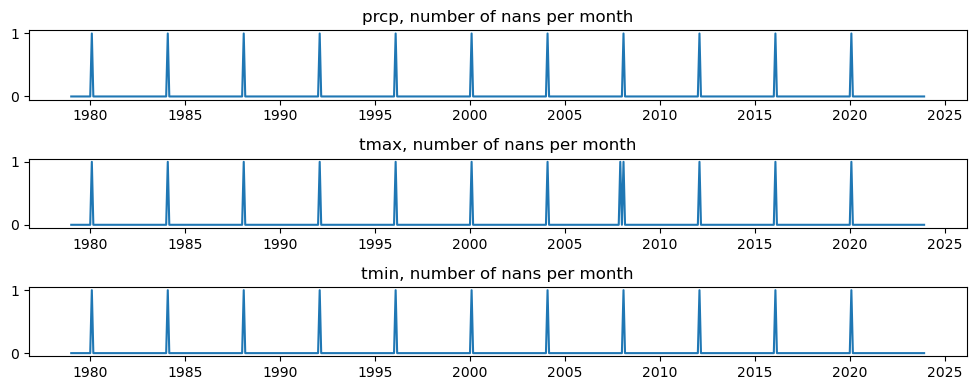

In [218]:
# create datetimes for the x axis
time_months=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='MS')

# plot
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(311)
plt.plot(time_months,pr_nan_per_month)
plt.title('prcp, number of nans per month')

ax=fig.add_subplot(312)
plt.plot(time_months,tx_nan_per_month)
plt.title('tmax, number of nans per month')

ax=fig.add_subplot(313)
plt.plot(time_months,tn_nan_per_month)
plt.title('tmin, number of nans per month')

plt.tight_layout()
plt.show()

# Calculate climate change indicators

### Monthly Maximum Value of Daily Minimum Temperature (TNx)

- max(each month of daily minimum temperature values)

Here we are inputting daily data and pulling out 1 value per month.

In [24]:
# this is similar to how we found nans per month

# create an index for every month in the timeseries
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# replace the time coordinate with the new month_groups index
# now each day of data in any particular month has the same label
tn.coords['month_groups']=('time',month_groups)    
tn

<xarray.DataArray 'tmin' (time: 16436)>
array([ -1.097348,  -8.009786, -10.346189, ...,   1.085255,  -1.805873,
         1.301268], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [25]:
# groupby month and find the maximum value of each month
TNx=tn.groupby('month_groups').max()
TNx

<xarray.DataArray 'tmin' (month_groups: 540)>
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon           float64 -88.8
    lat           float64 33.5
  * month_groups  (month_groups) object MultiIndex
  * time_level_0  (month_groups) int64 1979 1979 1979 1979 ... 2023 2023 2023
  * time_level_1  (month_groups) int64 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

Text(0, 0.5, 'degrees C')

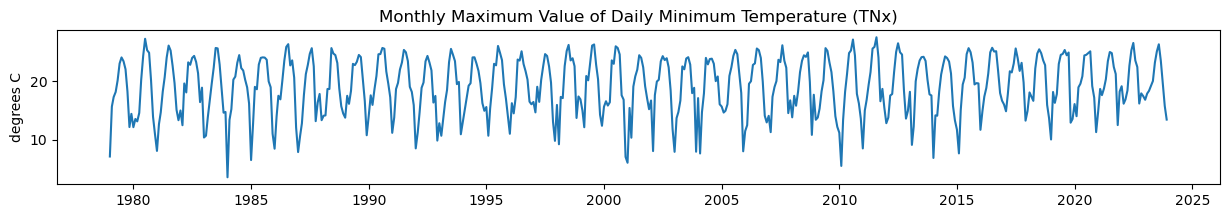

In [26]:
# using the monthly datetimes that we created earlier (time_months) for the x axis values, plot TNx

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_months,TNx)
plt.title('Monthly Maximum Value of Daily Minimum Temperature (TNx)')
plt.ylabel('degrees C')

### Growing Season Length (GSL)

- annually, growing season starts on the first day of the first six consecutive day period where daily mean temperature is > 5C
- annually, growing season ends on the first day after 1 July of the first six consecutive day period where daily mean temperature is < 5C

Here we are inputting daily data, pulling out 2 dates per year, and calculating the number of days between the two dates.


In [27]:
threshold = 5   # degrees C
window_len = 6  # consectutive days

# calculate mean temperature
t_mean=(tn+tx)/2

In [28]:
# to find the start and end of the growing season
# we will need to "roll" through time
# in order for the leap days (that we filled with nan)
# to not mess us up, we'll need to drop those days from the data

leapdays=t_mean.time[(t_mean.time.dt.day==29) & (t_mean.time.dt.month==2)]
t_mean_noleap=t_mean.drop_sel(time=leapdays)
len(leapdays),len(t_mean_noleap),len(t_mean)

(11, 16425, 16436)

In [29]:
# we'll want to group by years to find the start and end of the growing season for each year
# let's take a look at how to use groupby
t_mean_noleap.groupby(t_mean_noleap.time.dt.year)

DataArrayGroupBy, grouped over 'year'
45 groups with labels 1979, 1980, 1981, ..., 2022, 2023.

In [30]:
# how to access the group labels
t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups.keys()

dict_keys([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [31]:
# how to access the array indexes assigned to a group label
testyear=1979
t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups[testyear]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [32]:
# how to access the array data assigned to a group label
data_1yr=t_mean_noleap[t_mean_noleap.groupby(t_mean_noleap.time.dt.year).groups[testyear]]
data_1yr

<xarray.DataArray (time: 365)>
array([ 8.1353035 , -4.288802  , -4.4386454 , -0.8546457 ,  1.1774075 ,
        6.779866  ,  6.0748196 , -4.3675547 , -3.2942595 ,  0.11734867,
        0.77373075,  2.594514  ,  6.378198  , -3.3522277 , -1.9103057 ,
        2.890925  , 11.7818575 ,  9.920426  , 10.064592  , 11.158965  ,
       -0.4764247 , -1.6299584 ,  3.8228197 , -1.0631053 , -0.27095938,
       -0.23414445,  1.7851415 , -0.5003214 ,  0.1952014 ,  1.0431843 ,
       -1.8708985 , -1.0794535 ,  0.29778528,  4.0356693 ,  3.810256  ,
        1.7415557 ,  1.8159289 ,  3.236442  ,  3.9993129 , -2.4971035 ,
        0.21872807,  3.8254037 ,  7.8650293 ,  6.0996947 , 12.939138  ,
       16.741783  ,  7.9939957 ,  1.379816  ,  2.45297   ,  2.96456   ,
        5.355425  , 12.35103   , 16.464214  , 19.008556  , 17.166714  ,
        8.452247  ,  4.397326  ,  5.002684  ,  9.701976  , 11.323724  ,
       12.077646  , 16.609367  , 10.789961  ,  6.4605026 ,  8.075328  ,
       11.900557  ,  6.7615557 , 10.216373  ,  7.119954  ,  5.3154063 ,
       11.493533  , 12.259903  , 10.415325  ,  8.059163  ,  8.8126    ,
       14.2029915 , 16.698421  , 18.189552  , 17.78302   , 16.939842  ,
       17.775875  , 14.240146  ,  8.453808  ,  5.6677475 ,  7.598219  ,
       13.066741  , 16.420547  , 18.289589  , 18.387362  , 20.609434  ,
       21.617504  , 17.296993  , 15.194509  , 13.205258  , 11.844173  ,
       13.822305  , 15.880647  , 16.064568  , 13.496645  , 14.056612  ,
...
       20.966152  , 21.579288  , 22.338875  , 22.125307  , 17.978846  ,
       17.8994    , 15.852444  , 14.210393  , 17.352623  , 18.207617  ,
       21.671387  , 19.042458  , 11.6243725 , 14.649393  , 20.769947  ,
       14.808371  , 12.341598  , 14.419032  , 17.187122  , 18.906313  ,
       20.161898  , 21.415573  , 22.681904  , 23.35585   , 19.977499  ,
       12.528366  , 11.439746  , 11.905024  , 14.058121  , 16.675364  ,
       18.798317  , 18.587778  , 18.763556  , 19.393993  , 12.671651  ,
       11.690875  , 10.257289  ,  8.947262  , 10.468411  , 12.3520975 ,
        9.490822  , 11.935866  , 15.969742  , 11.480764  ,  8.64254   ,
        7.9788494 ,  7.248757  ,  5.994166  ,  7.061735  , 11.989148  ,
       11.849103  , 12.418754  , 14.961432  , 15.350905  , 16.49037   ,
       14.875176  ,  6.382844  ,  6.6305065 , 11.825587  , 10.300137  ,
       14.130825  ,  9.964463  ,  0.9073391 ,  0.33711958,  3.3090315 ,
        0.8996    ,  1.4090123 ,  4.22398   ,  7.8843946 ,  7.0836306 ,
        6.9091    ,  6.053909  ,  5.5644155 ,  9.734103  , 13.3338375 ,
       17.267231  , 11.69383   ,  5.816677  ,  5.877605  ,  6.921958  ,
       -1.572335  ,  0.1842575 ,  4.4846277 ,  8.791329  , 11.964463  ,
       10.386658  , 14.793819  , 12.270062  ,  6.4803944 ,  5.6211376 ,
        6.084346  ,  6.5973954 ,  8.828471  ,  6.243507  ,  5.918876  ],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)

In [33]:
# make a mask for where temperature is greater than 5C
data_mask=xr.where(data_1yr>threshold,1,0)
data_mask

<xarray.DataArray (time: 365)>
array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)

In [34]:
# separate the timeseries into windows of length 6
# the first window has the first value of the data_mask (index 0) in the last position of the window 
# plus the 5 preceeding values of the data_mask, which in this case are nan because we're working at the beginning of the data_mask array
# the 6th window (index 5) should be equal to the first 6 values of data_mask (no nans)
windows=data_mask.rolling(time=window_len,center=False).construct('window')
print(windows.isel(time=window_len-1))
windows


<xarray.DataArray (window: 6)>
array([1., 0., 0., 0., 0., 1.])
Coordinates:
    time          datetime64[ns] 1979-01-06
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  object (1979, 1)
Dimensions without coordinates: window


<xarray.DataArray (time: 365, window: 6)>
array([[nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan,  1.,  0.],
       [nan, nan, nan,  1.,  0.,  0.],
       ...,
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)
Dimensions without coordinates: window

In [35]:
# find the sum of each window
# this will tell us how many days per window are over the 5C threshold
windows.sum('window',min_count=window_len)

<xarray.DataArray (time: 365)>
array([nan, nan, nan, nan, nan,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
        1.,  1.,  1.,  2.,  3.,  3.,  4.,  4.,  4.,  3.,  2.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  4.,  3.,  3.,  3.,
        3.,  4.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,
        1.,  2.,  3.,  4.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,
        4.,  3.,  3.,  3.,  3.,  4.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)

In [36]:
# find the index of each 6-day window where all days were over the 5C threshold
np.where(windows.sum('window')==window_len)[0]

array([ 55,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 24

In [37]:
# now take the first value of the result above
# this is the first window where the requirement was met (6 days above 5C)
# the index of the window matches the last day of the window
# the start of the growing season is the first day of the first 6-day period meeting the 5C requirement
# so to get the index of the first day in the window we subtract 5
gs_start_ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
gs_start_ind

50

In [38]:
# now let's search for the end of the growing season
# we know to only look after July 1, what index is that?
testlabel=str(testyear)+'-07-01'
minval=t_mean.indexes['time'].get_loc(testlabel)
minval

181

In [39]:
# 0/1 mask for where temperature is less than 5C
data_mask=xr.where(data_1yr<threshold,1,0)
data_mask

<xarray.DataArray (time: 365)>
array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)

In [40]:
# split up into 6-day windows
windows=data_mask.rolling(time=window_len,center=False).construct('window')
windows

<xarray.DataArray (time: 365, window: 6)>
array([[nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan,  0.,  1.,  1.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)
Dimensions without coordinates: window

In [41]:
# get the index to all the windows where temperature is always less than 5C
np.where(windows.sum('window')==window_len)

(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41, 337], dtype=int64),)

In [42]:
# get the index to all the windows where temperature is lt 5C
# but remember the index is to the last date in the window and we want the index of the first date
# so we subtract 5 and save the result as an array
possible_inds=np.where(windows.sum('window')==window_len)[0] - (window_len-1)
possible_inds

array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36, 332], dtype=int64)

In [43]:
# subset possible_inds to only indexes that correspond to days after July 1
# and take the first value in that result
gs_end_ind=possible_inds[possible_inds>minval][0]
gs_end_ind

332

In [44]:
# functions to do what we did above for each year
# we'll put these functions in a loop below

def get_gs_start(data_1yr):
    mask=xr.where(data_1yr>threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
    return ind

def get_gs_end(data_1yr):
    mask=xr.where(data_1yr<threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    # sometimes it may be warm through the end of the year
    # in these cases we would end up with an error if no windows meet the <5C requirement
    # try/except works to pass in the last day of the year as the end of the growing season in these cases
    try:
        possible_inds=np.where(windows.sum('window')==window_len)[0]
        ind=possible_inds[possible_inds>minval][0]
    except:
        ind=364
    return ind

In [45]:
# group the data by year and loop through each year's worth of data
# to find the index of the start and end of the growing season 

# create empty lists for storing results
gs_start_list=[]
gs_end_list=[]

# loop through years of data
# .groupby returns a dictionary of keys and values
# here we call the keys "label" which are the years
# and the values "group" which are a year's worth of data values
for label,group in t_mean_noleap.groupby(t_mean_noleap.time.dt.year):
    # call our functions and append the result to our lists
    gs_start_list.append(get_gs_start(group))
    gs_end_list.append(get_gs_end(group))

# look at the first 5 values of each list
gs_start_list[0:5], gs_end_list[0:5]

([50, 12, 22, 0, 5], [337, 364, 364, 364, 360])

In [46]:
# double check our work
assert all(x>=0 for x in gs_start_list), "negative values in gs_start_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_start_list"
assert all(x>=minval for x in gs_end_list), f"values<{minval} in gs_end_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_end_list"

In [47]:
# calculate the growing season length for each year
# this is called a "list comprehension"
# it puts an entire for loop inside a list
GSL = [end_ind-start_ind for end_ind,start_ind in zip(gs_end_list,gs_start_list)] 

# # below is identical to above
# GSL=[]
# for end_ind,start_ind in zip(gs_end_list,gs_start_list):
#     GSL.append(end_ind-start_ind)

# check out the first 5 values
GSL[0:5]

[287, 352, 342, 364, 355]

Text(0.5, 1.0, 'End of Growing Season DOY')

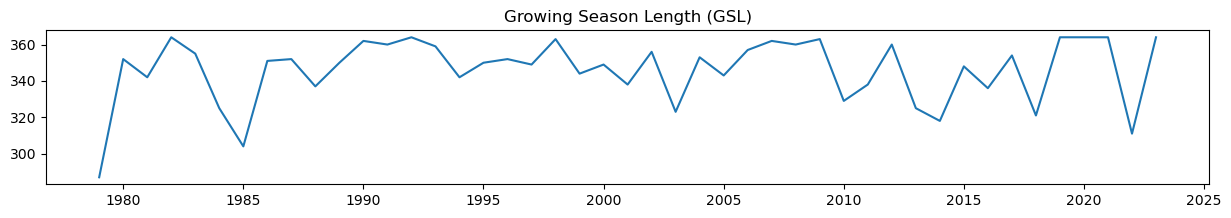

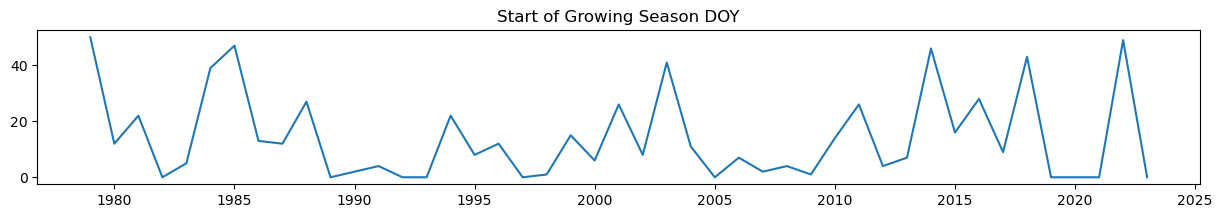

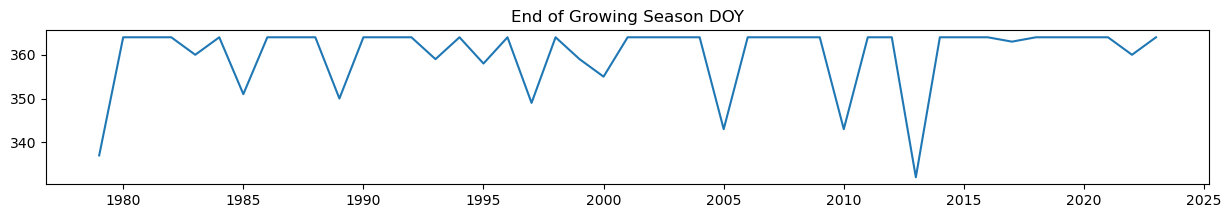

In [48]:
# annual datetimes for x axis values, plot gsl
time_annual=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='YS')

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,GSL)
plt.title('Growing Season Length (GSL)')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_start_list)
plt.title('Start of Growing Season DOY')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_end_list)
plt.title('End of Growing Season DOY')

### Warm Spell Duration Index (WSDI)

- 6 consecutive days of hot maximum temperatures
- hot temperature threshold defined as > 90th percentile of maximum temperature for each calendar day using a centered 5-day window in the base period 1981-2010
- warm spells that contain dates for multiple years are assigned to the year when the spell ends

Here we first use daily data during the base period to determine the daily 90th percentile temperature threshold. Then using all years of daily data we decide whether each calendar day exceeds the hot threshold, then find occurrences where the threshold is exceeded for at least 6 consecutive days (this is a warm spell), then sum the number of days annually in the warm spells.

Notice that this is not the same as finding dangerous heat waves with respect to human health because it is based on a temperature threshold for each calendar day. This means that the WSDI will include winter warm spells where the temperature exceeds the 90th percentile of winter daily temperature, which would likely be a comfortable temperature.

In [95]:
# first let's find the 90th percentile temperature for each calendar day (using a centered 5 day window)
# this means that to determine the 90th percentile temperature for a given day we need 
# that day's temperature in each year as well as the temperature for 2 days before and 2 days after in each year
# we'll set it up to find the answer for 1 day first and then make a loop to compute all other days

# starting with Feb 1



n_baseyrs=30
# base_first='1981'
# base_last='2010'

day_first=1
day_last=365
doy=list(np.arange(day_first,day_last+1))*n_baseyrs
doy= [364,365] + doy + [1,2]

len(doy), doy[0:9]


(10954, [364, 365, 1, 2, 3, 4, 5, 6, 7])

In [96]:
tx_noleap_baseyrs=tx.drop_sel(time=leapdays).sel(time=slice('1980-12-30','2011-01-02'))
tx_noleap_baseyrs

<xarray.DataArray 'tmax' (time: 10954)>
array([ 8.176911, 13.757484, 11.529253, ..., 18.626957, 17.474537,  6.330043],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1980-12-30 1980-12-31 ... 2011-01-02
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1980, 12) (1980, 12) ... (2011, 1) (2011, 1)
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [97]:
tx_noleap_baseyrs.coords['doy_noleap']=('time',doy)
tx_noleap_baseyrs

<xarray.DataArray 'tmax' (time: 10954)>
array([ 8.176911, 13.757484, 11.529253, ..., 18.626957, 17.474537,  6.330043],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1980-12-30 1980-12-31 ... 2011-01-02
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1980, 12) (1980, 12) ... (2011, 1) (2011, 1)
    doy_noleap    (time) int32 364 365 1 2 3 4 5 6 ... 361 362 363 364 365 1 2
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [98]:
tx_windows=tx_noleap_baseyrs.rolling(time=5,center=True).construct('window')
tx_windows


<xarray.DataArray 'tmax' (time: 10954, window: 5)>
array([[      nan,       nan,  8.176911, 13.757484, 11.529253],
       [      nan,  8.176911, 13.757484, 11.529253,  9.400941],
       [ 8.176911, 13.757484, 11.529253,  9.400941, 13.948999],
       ...,
       [13.695868, 17.547812, 18.626957, 17.474537,  6.330043],
       [17.547812, 18.626957, 17.474537,  6.330043,       nan],
       [18.626957, 17.474537,  6.330043,       nan,       nan]],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1980-12-30 1980-12-31 ... 2011-01-02
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1980, 12) (1980, 12) ... (2011, 1) (2011, 1)
    doy_noleap    (time) int32 364 365 1 2 3 4 5 6 ... 361 362 363 364 365 1 2
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [99]:
# drop the windows centered on the extra dates
tx_windows=tx_windows.drop_sel(time=['1980-12-30','1980-12-31','2011-01-1','2011-01-02'])
tx_windows

<xarray.DataArray 'tmax' (time: 10950, window: 5)>
array([[ 8.176911, 13.757484, 11.529253,  9.400941, 13.948999],
       [13.757484, 11.529253,  9.400941, 13.948999,  5.021082],
       [11.529253,  9.400941, 13.948999,  5.021082,  3.742096],
       ...,
       [ 4.907838,  8.568268, 13.695868, 17.547812, 18.626957],
       [ 8.568268, 13.695868, 17.547812, 18.626957, 17.474537],
       [13.695868, 17.547812, 18.626957, 17.474537,  6.330043]],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1981, 1) (1981, 1) ... (2010, 12) (2010, 12)
    doy_noleap    (time) int32 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [75]:
# now groupby our doy index 'doy_noleap'
# each group will contain the temperature for a single doy of every year plus the two days before and two days after
# in other words, each group is the 5-day centered window for a given doy for all years 
# 5 days * 30 years = 150 data values in each group
tx_grouped=tx_windows.groupby(tx_windows.doy_noleap)

# let's look at what is in a data group for doy 15
tx_grouped[15]

<xarray.DataArray 'tmax' (time: 30, window: 5)>
array([[ 9.83393097e+00,  1.31945992e+01,  9.41759396e+00,
         5.91370678e+00,  3.05930424e+00],
       [ 3.39484215e-03, -1.28558278e+00,  1.04767542e+01,
         5.66890144e+00,  6.54544830e-01],
       [ 1.37191830e+01,  1.71481285e+01,  7.47580147e+00,
         6.62147903e+00,  1.03485222e+01],
       [ 8.09697533e+00,  7.41584873e+00,  4.14011383e+00,
         5.62060642e+00,  6.09023380e+00],
       [ 4.05518103e+00,  8.86803055e+00,  4.91449928e+00,
         5.25756073e+00,  3.12758350e+00],
       [ 8.18523884e+00,  1.46367874e+01,  1.33811169e+01,
         1.70298901e+01,  1.77742996e+01],
       [ 1.57109356e+01,  1.17041140e+01,  1.25284605e+01,
         1.12611322e+01,  1.27316322e+01],
       [ 8.49998856e+00,  5.40577602e+00,  9.44757080e+00,
         1.22819891e+01,  1.53129177e+01],
       [ 9.47088528e+00,  1.60989609e+01,  7.76057529e+00,
         9.81894302e+00,  1.24085550e+01],
       [ 7.46914005e+00,  1.22919807e+01,  1.73546314e+01,
         1.92964249e+01,  1.98842926e+01],
...
       [ 1.10896015e+01,  1.29597855e+01,  1.37058601e+01,
         8.85803795e+00,  5.94368267e+00],
       [ 1.30330601e+01,  1.52063370e+01,  1.04484434e+01,
         1.23902369e+01,  1.45768356e+01],
       [ 8.40173340e+00,  1.06349621e+01,  7.01450062e+00,
         8.22021103e+00,  2.68626690e+00],
       [ 1.74079227e+01,  1.72563763e+01,  1.24585152e+01,
         1.35276680e+01,  1.04950733e+01],
       [ 1.82705727e+01,  9.29935455e+00,  1.09180708e+01,
         6.53321552e+00,  3.07762289e+00],
       [ 1.42987232e+01,  9.16279602e+00,  1.12528057e+01,
         1.68050671e+01,  1.57342510e+01],
       [ 2.21658154e+01,  2.04155369e+01,  1.70415478e+01,
         4.05018473e+00,  3.99023247e+00],
       [ 1.21004658e+01,  1.08497915e+01,  1.02119646e+01,
         7.16105080e+00,  8.56327152e+00],
       [ 7.52909184e+00,  1.01936455e+01,  2.85446692e+00,
        -1.15933418e-02,  5.23591137e+00],
       [ 7.36089230e+00,  9.98714256e+00,  1.28815136e+01,
         1.04184675e+01,  9.44590473e+00]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1981-01-15 1982-01-15 ... 2010-01-15
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1981, 1) (1982, 1) ... (2009, 1) (2010, 1)
    doy_noleap    (time) int32 15 15 15 15 15 15 15 15 ... 15 15 15 15 15 15 15
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [93]:
# now find the 90th percentile of data values in each group
# we should end up with 1 value for each doy of the year (excluding leap days)
threshold90=tx_grouped.quantile(0.9,dim=['time','window'])
threshold90

<xarray.DataArray 'tmax' (doy_noleap: 365)>
array([19.21382408, 19.79935951, 19.60451355, 20.19121475, 19.89095345,
       18.49139786, 18.12502117, 18.58132572, 18.58132572, 18.6336174 ,
       18.6336174 , 18.6066391 , 18.26307793, 17.49335499, 17.35996056,
       17.26103935, 17.39659824, 17.98479939, 18.05974007, 17.94483089,
       18.4116272 , 18.45559235, 18.88874912, 19.14454536, 19.14454536,
       19.10757446, 19.16003304, 19.03296661, 18.22077808, 18.98000965,
       19.47328415, 19.47328415, 20.0325079 , 20.10828133, 20.0325079 ,
       19.36104126, 19.39951077, 20.08596497, 20.09012966, 20.09012966,
       20.09012966, 19.95706787, 19.97605267, 20.29496593, 20.71146889,
       20.89682331, 21.28334923, 21.23488846, 20.99457855, 21.28334923,
       21.50733833, 21.10848713, 20.81472034, 21.60509396, 21.60509396,
       21.60509396, 21.01339722, 21.4971796 , 22.56683197, 22.41761551,
       22.68457146, 22.98133507, 23.11139984, 23.47094669, 23.66512718,
       23.93607788, 23.98320789, 24.09844952, 24.1682272 , 24.35074978,
       25.10315247, 25.1322958 , 24.13508739, 24.09478588, 24.15324001,
       24.23267632, 24.56691074, 24.56691074, 24.57940102, 24.72944889,
       24.59388943, 24.36307373, 24.81671371, 25.05402565, 25.65854626,
       26.21826801, 26.50504093, 26.39912395, 26.24058437, 25.9428194 ,
       25.68552456, 25.9428194 , 26.33350983, 26.92987099, 26.91971245,
       27.02762566, 27.09723816, 27.02762566, 26.96784   , 26.81296291,
...
       32.12291718, 32.02932663, 31.64263382, 31.33420868, 31.17567024,
       30.83094368, 31.04843597, 31.30273399, 31.08241005, 31.45294838,
       31.09156952, 30.79663506, 30.57448006, 30.33949928, 30.18445473,
       29.62939606, 29.45353546, 29.3389595 , 28.19203568, 27.89876938,
       27.80500984, 27.89876938, 27.89610481, 27.81366959, 27.77270241,
       27.88861008, 27.29358139, 27.20881596, 27.1390379 , 27.14819679,
       27.05577106, 27.1002346 , 27.1002346 , 27.09257393, 27.11738815,
       27.31156769, 27.31156769, 27.30807037, 27.00198021, 26.7063818 ,
       25.99677677, 25.5532959 , 24.77724533, 24.4017086 , 24.03200264,
       24.23817291, 24.14907551, 24.14907551, 24.14907551, 23.84848137,
       23.76071796, 23.54505596, 23.3383852 , 23.35437241, 23.10756931,
       22.6241188 , 22.45275517, 22.43926601, 22.14283371, 22.06356411,
       21.42523613, 21.44005775, 22.07788639, 22.00894032, 22.00894032,
       22.12634659, 22.00894032, 21.2328886 , 21.1699398 , 21.03587837,
       20.85085964, 20.85085964, 20.93179455, 20.68698883, 19.86230965,
       19.88962097, 19.83982677, 19.76721878, 19.89828053, 20.01452236,
       19.77837677, 19.96056576, 19.69610901, 19.69294472, 19.69261169,
       19.62966003, 18.72388   , 19.73640938, 18.61596565, 18.61596565,
       19.1388834 , 18.91272984, 18.63544903, 19.17635365, 19.10574303,
       18.69956474, 19.15153999, 19.15153999, 18.6925705 , 18.91739311])
Coordinates:
    quantile    float64 0.9
  * doy_noleap  (doy_noleap) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

In [101]:
# prep tx for comparison to threshold90
# this time use all data (don't subset in time)
nyears=45
doy=list(np.arange(day_first,day_last+1))*nyears
tx_noleap=tx.drop_sel(time=leapdays)
tx_noleap.coords['doy_noleap']=('time',doy)
tx_noleap


<xarray.DataArray 'tmax' (time: 16425)>
array([17.367954, -0.567819,  1.468899, ...,  8.485001, 10.082067, 15.89912 ],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)
    doy_noleap    (time) int32 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [102]:
# determine which days exceed threshold90
# these are the hot days
tx_hot_mask = tx_noleap.groupby(tx_noleap.doy_noleap) > threshold90
tx_hot_mask

<xarray.DataArray 'tmax' (time: 16425)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)
    doy_noleap    (time) int32 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    quantile      (time) float64 0.9 0.9 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9 0.9

In [117]:
# how many True days and how many False?
ntrue=tx_hot_mask.sum()
nfalse=len(tx_hot_mask)-ntrue
ntrue,nfalse

(<xarray.DataArray 'tmax' ()>
 array(1788)
 Coordinates:
     lon      float64 -88.8
     lat      float64 33.5,
 <xarray.DataArray 'tmax' ()>
 array(14637)
 Coordinates:
     lon      float64 -88.8
     lat      float64 33.5)

In [158]:
tx_hot_mask.time.isel(time=6).data + np.timedelta64(1,'D')#.data#,tx_hot_mask.time.isel(time=6).data.timedelta(days=1)
# tx_hot_mask.time.isel(time=6).dt.strftime("%a, %b %d %H:%M").data
# tx_hot_mask.time.isel(time=6).dt.strftime("%Y-%m-%d").timedelta(days=1)
window_len

6

In [165]:
i=6
np.arange(i-(window_len-1),i+1)

# tx_hot_mask.isel(time=6)
date=tx_hot_mask.time.isel(time=i).data
print(date)
dates=pd.date_range(date-np.timedelta64(window_len-1,'D'),date-np.timedelta64(0,'D'))
dates

1979-01-07T00:00:00.000000000


DatetimeIndex(['1979-01-02', '1979-01-03', '1979-01-04', '1979-01-05',
               '1979-01-06', '1979-01-07'],
              dtype='datetime64[ns]', freq='D')

In [166]:
# we'll loop in time to identify warm spells in each year and sum the days in warm
count=0
hot_inds=[]
hot_dates=[]
# event_year=[]

for i,value in enumerate(tx_hot_mask):
    if value: count=count+1 # if True start a counter
    else: count=0

    if count>=window_len:
        inds=np.arange(i-(window_len-1),i+1)
        hot_inds.extend(inds)

        # date=tx_hot_mask.time.isel(time=i).data
        # dates=pd.date_range(date-np.timedelta64(window_len-1,'D'),date-np.timedelta64(0,'D'))
        # hot_dates.extend(dates)
     

    # if i < window_len-1:
len(hot_dates)

1116

In [170]:
hot_inds=np.unique(hot_inds)
len(hot_inds)

441

In [171]:
hot_dates=np.unique(hot_dates)
len(hot_dates)

441

In [176]:
# now we need to know which year each warm spell event takes place in
# warm spell days are counted for the year when the spell ends
# are there any warm spells that span over two years?
ind1=None
event_inds=[]
for i,value in enumerate(hot_inds[:-1]):
    if ind1==None:
        ind1=value

    if hot_inds[i+1]==value+1:
        pass
    else:
        ind2=value
        event_inds.append((ind1,ind2)) # append a tuple
        ind1=hot_inds[i+1]

print(len(event_inds))
event_inds

50


[(545, 564),
 (613, 623),
 (926, 931),
 (1167, 1173),
 (2170, 2179),
 (2340, 2346),
 (2643, 2651),
 (2761, 2766),
 (2822, 2831),
 (3125, 3132),
 (3459, 3464),
 (3761, 3767),
 (4251, 4256),
 (4259, 4266),
 (4634, 4640),
 (6339, 6351),
 (7206, 7212),
 (7270, 7275),
 (7336, 7341),
 (7901, 7911),
 (7958, 7971),
 (9957, 9963),
 (9998, 10006),
 (10046, 10056),
 (10069, 10075),
 (10300, 10308),
 (10439, 10447),
 (10738, 10744),
 (11116, 11128),
 (11526, 11531),
 (11571, 11582),
 (11755, 11760),
 (11831, 11837),
 (11840, 11849),
 (12117, 12124),
 (12189, 12194),
 (12218, 12229),
 (13495, 13501),
 (13767, 13773),
 (13802, 13812),
 (13879, 13886),
 (14284, 14289),
 (14492, 14497),
 (14511, 14517),
 (14742, 14749),
 (14849, 14861),
 (14865, 14878),
 (15611, 15617),
 (15687, 15695),
 (15857, 15863)]

In [188]:
tx_hot_mask.isel(time=slice(544,566))

<xarray.DataArray 'tmax' (time: 22)>
array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])
Coordinates:
  * time          (time) datetime64[ns] 1980-06-29 1980-06-30 ... 1980-07-20
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1980, 6) (1980, 6) ... (1980, 7) (1980, 7)
    doy_noleap    (time) int32 180 181 182 183 184 185 ... 197 198 199 200 201
    quantile      (time) float64 0.9 0.9 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9 0.9

In [181]:
tx_hot_mask.time.isel(time=event_inds[0][0]).dt.year.data


array(1980, dtype=int64)

In [183]:
# do owe have any warm spells that span over multiple years
spell_year=[]
count=0
for startstop in event_inds:
    year_start=tx_hot_mask.time.isel(time=startstop[0]).dt.year.data
    year_end = tx_hot_mask.time.isel(time=startstop[1]).dt.year.data
    if year_start==year_end:
        spell_year.append(year_start)
    else:
        spell_year.append(year_end)
        count+=1
print(count)
spell_year

1


[array(1980, dtype=int64),
 array(1980, dtype=int64),
 array(1981, dtype=int64),
 array(1982, dtype=int64),
 array(1984, dtype=int64),
 array(1985, dtype=int64),
 array(1986, dtype=int64),
 array(1986, dtype=int64),
 array(1986, dtype=int64),
 array(1987, dtype=int64),
 array(1988, dtype=int64),
 array(1989, dtype=int64),
 array(1990, dtype=int64),
 array(1990, dtype=int64),
 array(1991, dtype=int64),
 array(1996, dtype=int64),
 array(1998, dtype=int64),
 array(1998, dtype=int64),
 array(1999, dtype=int64),
 array(2000, dtype=int64),
 array(2000, dtype=int64),
 array(2006, dtype=int64),
 array(2006, dtype=int64),
 array(2006, dtype=int64),
 array(2006, dtype=int64),
 array(2007, dtype=int64),
 array(2007, dtype=int64),
 array(2008, dtype=int64),
 array(2009, dtype=int64),
 array(2010, dtype=int64),
 array(2010, dtype=int64),
 array(2011, dtype=int64),
 array(2011, dtype=int64),
 array(2011, dtype=int64),
 array(2012, dtype=int64),
 array(2012, dtype=int64),
 array(2012, dtype=int64),
 

In [195]:
# count days in warm spells per year
WSDI=[]
for data_year in np.arange(1979,2023+1):
    day_count=0
    for i,event_year in enumerate(spell_year):
        if event_year==data_year:
            ndays=event_inds[i][1]-event_inds[i][0]+1
        else:
            ndays=0    
        day_count=day_count+ndays
    WSDI.append(day_count)
len(WSDI)

45

Text(0.5, 1.0, 'Warm Spell Duration Index (WSDI)')

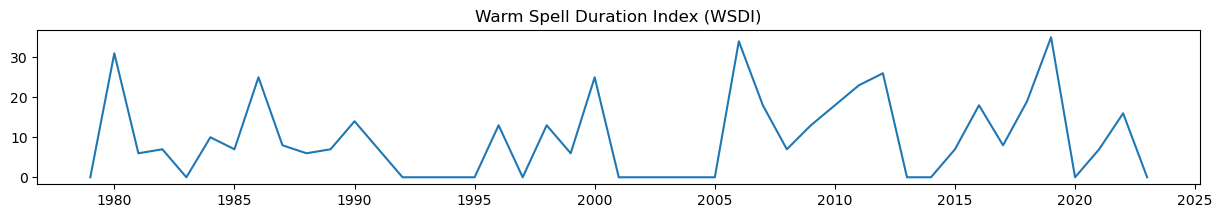

In [196]:
# using annual datetimes that we've already created for x axis values
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,WSDI)
plt.title('Warm Spell Duration Index (WSDI)')

### Monthly Maximum Consecutive 5-day Precipitation (Rx5day)

- max(5-day rolling mean precipitation within each month)

Here we are inputting daily data, for each month calculating the mean precipitation amount for each 5-day window of data values, then choosing the maximum of 5-day window value for each month.


In [219]:
pr_noleap=pr.drop_sel(time=leapdays)
pr_noleap

<xarray.DataArray 'prcp' (time: 16425)>
array([31.362183,  0.      ,  0.      , ...,  0.213654,  0.      ,  0.      ],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [220]:
pr_noleap.groupby(pr_noleap.month_groups)

DataArrayGroupBy, grouped over 'month_groups'
540 groups with labels (1979,, 1), ..., (2023,, 12).

In [224]:
window_len=5
pr_noleap[pr_noleap.groupby(pr_noleap.month_groups).groups[(1979,5)]].rolling(time=window_len,center=False,min_periods=window_len).mean().max()

<xarray.DataArray 'prcp' ()>
array(9.5278015, dtype=float32)
Coordinates:
    lon      float64 -88.8
    lat      float64 33.5

In [228]:
result=[]
for label,group in pr_noleap.groupby(pr_noleap.month_groups):
    result.append(group.rolling(time=window_len,center=False,min_periods=window_len).mean().max())
result[0]

<xarray.DataArray 'prcp' ()>
array(21.193508, dtype=float32)
Coordinates:
    lon      float64 -88.8
    lat      float64 33.5

In [232]:
Rx5day=xr.concat(result,dim='time')
Rx5day.coords['time']=('time',time_months)    
Rx5day

<xarray.DataArray 'prcp' (time: 540)>
array([21.193508  , 12.252375  ,  8.633856  , 19.149258  ,  9.5278015 ,
        3.8091552 , 25.303371  ,  8.901709  , 15.566882  ,  4.9857483 ,
       16.408253  ,  8.175375  ,  9.225433  , 11.576981  , 19.671824  ,
       23.612427  , 17.308767  ,  7.1138062 ,  7.7941346 ,  1.4921204 ,
       15.08869   ,  8.955933  , 11.7183075 ,  4.047427  ,  5.066272  ,
        7.526273  , 11.695297  ,  4.711319  ,  8.124433  ,  6.7292876 ,
        6.9314055 ,  6.418695  ,  8.315054  ,  8.673291  ,  9.817017  ,
        5.0679197 , 15.187281  ,  9.228724  ,  5.488599  , 21.622406  ,
        4.1871095 ,  9.503159  , 12.84725   , 10.706037  ,  3.7023377 ,
       10.4168215 , 14.84548   , 20.412952  ,  7.4983397 , 13.046082  ,
       14.206241  , 27.74201   , 30.99079   ,  9.728284  ,  3.485431  ,
        3.470642  ,  5.130353  ,  9.148193  , 12.275378  , 17.530615  ,
        6.7785735 ,  7.9716096 , 12.747004  , 13.673816  , 13.663959  ,
        3.9800599 ,  4.418817  , 16.079596  ,  3.191278  , 13.41582   ,
        7.3783846 ,  5.163226  ,  8.374212  ,  7.9633913 ,  7.332367  ,
        5.3259153 , 10.546646  ,  5.3012633 , 14.294989  ,  7.948593  ,
       10.125949  , 18.270102  ,  4.3235106 ,  7.953537  ,  3.5988069 ,
        5.8583403 , 11.25654   ,  3.4919922 , 16.927526  , 10.809573  ,
        2.6424255 ,  6.749002  , 12.275381  , 15.3319    , 16.85523   ,
        8.055426  , 17.359715  , 21.27074   ,  9.692126  ,  4.279138  ,
...
       13.09374   , 14.411654  ,  8.462952  ,  7.432602  ,  6.5452394 ,
        6.965912  ,  4.522345  ,  2.8429017 ,  2.118219  , 15.907043  ,
       11.16123   , 24.478443  ,  7.3011446 ,  6.395694  , 11.031405  ,
       17.34657   , 16.393467  ,  3.3096008 , 17.719595  ,  5.3883576 ,
        6.7358522 ,  5.1648684 ,  8.972376  ,  6.6339693 , 16.888088  ,
        8.23617   , 13.343518  , 10.287005  ,  7.894376  ,  6.8837495 ,
        9.614893  , 16.066452  ,  7.06944   ,  9.848242  , 18.206013  ,
       16.465763  , 26.770828  ,  6.9429107 , 15.907049  , 14.676227  ,
       15.13635   , 10.07666   , 24.64606   ,  0.12653808, 20.066217  ,
        7.2732058 ,  9.481787  , 16.015503  , 21.926418  , 25.027304  ,
       21.239523  ,  7.3997407 ,  9.785803  ,  4.6998167 ,  4.76062   ,
       15.382843  ,  8.752176  ,  8.377493  , 10.503916  ,  6.91333   ,
        7.256778  , 15.877466  , 10.855578  , 13.041153  , 21.670063  ,
       10.968969  , 23.145733  ,  7.897662  ,  4.0835814 ,  3.661255  ,
        4.28407   , 15.994141  , 16.993265  , 10.844068  , 11.149729  ,
       12.755221  ,  4.640668  ,  7.8713684 , 23.388943  ,  8.104715  ,
        4.786905  ,  7.624869  , 10.464475  , 11.396219  , 10.679743  ,
        9.141632  , 17.343283  ,  5.9076414 , 30.879053  , 12.467642  ,
        2.5520446 ,  3.2915223 ,  0.913678  ,  7.8056335 ,  6.8689575 ],
      dtype=float32)
Coordinates:
    lon      float64 -88.8
    lat      float64 33.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01

Text(0.5, 1.0, 'Monthly Maximum Consecutive 5-day Precipitation (Rx5day)')

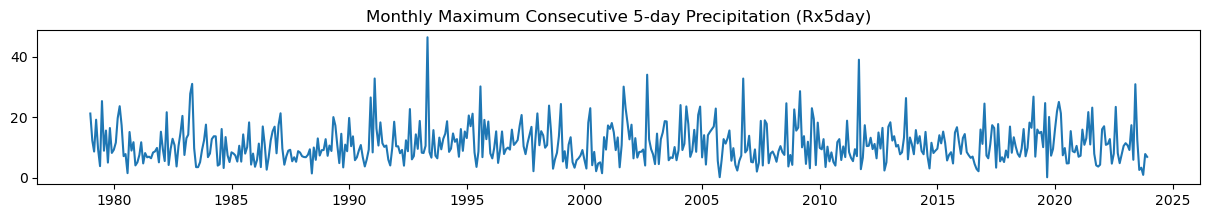

In [234]:
# using monthly datetimes that we've already created for x axis values
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(Rx5day.time,Rx5day)
plt.title('Monthly Maximum Consecutive 5-day Precipitation (Rx5day)')

### Maximum Length of Consecutive Dry Days (CDD)

- annually, during the growing season (using mean start and mean end)
- maximum length of consecutive days where precipitation is < 1mm

Here we are inputting daily data, subsetting to data during the mean growing season, determining whether each day falls under the precipitation threshold, and finding the longest period of consecutive days each year that meets the threshold requirement. 


### Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)

- annually, the sum of precipitation when precipitation is > 99th percentile of wet day precipitation in the base period 1981-2010
- where a wet day is precipitation >= 1mm

Here we first use daily data during the base period to determine the 99th percentile of wet day precipitation. Then for each year of daily data we determine if each day exceeds the threshold and calculate an annual sum of precip on days that exceed the threshold. 

In [235]:
# first slice to the base years
pr_baseyrs=pr_noleap.sel(time=slice('1981','2010'))
pr_baseyrs

<xarray.DataArray 'prcp' (time: 10950)>
array([ 0.      ,  0.      ,  0.      , ...,  3.92746 ,  7.731689, 17.509262],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1981, 1) (1981, 1) ... (2010, 12) (2010, 12)
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [237]:
# find 99th percentile of wet day precipitation
pr_99w=xr.where(pr_baseyrs>1.0,pr_baseyrs,np.nan).quantile(0.90,dim='time')
pr_99w

<xarray.DataArray 'prcp' ()>
array(23.82277527)
Coordinates:
    quantile  float64 0.9

In [246]:
test=pr_noleap.copy()
test=test.assign_coords({'time':pr_noleap.month_groups})
# test


pr_2D=test.unstack('time')
pr_2D

<xarray.DataArray 'prcp' (time_level_0: 45, time_level_1: 12)>
array([[2.30072021e-01, 1.08703613e+01, 1.20782471e+00, 8.23974609e-03,
        2.56353760e+00, 0.00000000e+00, 7.39746094e-02, 1.33108521e+00,
        5.42297363e-01, 1.70080566e+01, 0.00000000e+00, 1.33929443e+00],
       [5.58746338e-01, 0.00000000e+00, 0.00000000e+00, 1.02706909e+00,
        0.00000000e+00, 8.23974609e-03, 1.06842041e-01, 2.62939453e-01,
        4.70803833e+00, 0.00000000e+00, 0.00000000e+00, 8.23974609e-03],
       [2.38281250e-01, 1.90621948e+00, 1.97204590e-01, 9.20257568e-01,
        1.36228790e+01, 1.80786133e-01, 0.00000000e+00, 5.94873047e+00,
        0.00000000e+00, 1.64489746e-02, 2.11820068e+01, 1.81172791e+01],
       [1.01884155e+01, 2.79388428e-01, 1.16920166e+01, 3.27838135e+00,
        1.06731873e+01, 2.38281250e-01, 2.04918213e+01, 2.27597046e+00,
        0.00000000e+00, 0.00000000e+00, 1.03363037e+01, 4.05892944e+00],
       [1.70904541e+00, 3.13128815e+01, 3.61541748e-01, 8.23974609e-03,
        1.62686157e+00, 2.99902344e+00, 4.02606201e+00, 2.79388428e-01,
        0.00000000e+00, 0.00000000e+00, 1.23260498e-01, 0.00000000e+00],
       [0.00000000e+00, 1.11746216e+00, 7.88787842e-01, 1.03034363e+01,
        0.00000000e+00, 1.32287598e+00, 8.46313477e-01, 3.61541748e-01,
        1.23248291e+00, 0.00000000e+00, 3.04830933e+00, 1.79940796e+00],
       [2.22912292e+01, 8.23974609e-03, 1.40337067e+01, 7.31292725e-01,
        0.00000000e+00, 7.72369385e-01, 0.00000000e+00, 1.47918701e-01,
...
        0.00000000e+00, 0.00000000e+00, 3.94390869e+00, 1.06814575e+00],
       [0.00000000e+00, 5.97335815e+00, 0.00000000e+00, 0.00000000e+00,
        1.97204590e-01, 2.62939453e-01, 8.14251709e+00, 1.73367310e+00,
        8.23974609e-03, 1.42968750e+00, 1.54387054e+01, 1.47485352e+01],
       [0.00000000e+00, 6.41705322e+00, 9.03930664e-02, 0.00000000e+00,
        0.00000000e+00, 1.69259644e+00, 3.04016113e-01, 0.00000000e+00,
        0.00000000e+00, 1.50525360e+01, 1.56523438e+01, 0.00000000e+00],
       [6.81976318e-01, 0.00000000e+00, 1.71559448e+01, 0.00000000e+00,
        0.00000000e+00, 1.34750366e+00, 4.75732422e+00, 3.45913696e+00,
        0.00000000e+00, 0.00000000e+00, 4.11071777e-02, 2.54627686e+01],
       [1.21603394e+00, 1.16262817e+01, 4.47221222e+01, 1.64489746e-02,
        0.00000000e+00, 1.13388062e+00, 8.23974609e-03, 4.97918701e+00,
        2.37126770e+01, 0.00000000e+00, 0.00000000e+00, 1.43789673e+00],
       [0.00000000e+00, 0.00000000e+00, 8.23974609e-03, 6.16241455e-01,
        2.71148682e-01, 1.36393127e+01, 3.04010010e+00, 8.23974609e-03,
        0.00000000e+00, 2.46520996e-01, 6.72927856e+00, 8.62731934e-01],
       [9.43249512e+00, 0.00000000e+00, 1.98509369e+01, 1.97204590e-01,
        1.56127930e-01, 1.01065063e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.98840332e+00, 0.00000000e+00]],
      dtype=float32)
Coordinates:
  * time_level_0  (time_level_0) int64 1979 1980 1981 1982 ... 2021 2022 2023
  * time_level_1  (time_level_1) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time_level_0, time_level_1) object (1979, 1) ... (2023, 12)
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [247]:
R99pTOT=xr.where(pr_2D>pr_99w,pr_2D,np.nan).sum('time_level_1')
R99pTOT

<xarray.DataArray 'prcp' (time_level_0: 45)>
array([  0.      ,   0.      ,   0.      ,   0.      ,  31.312881,
         0.      ,  43.826523,   0.      ,  32.586426,   0.      ,
        29.127304,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,  39.529327,  38.78984 ,   0.      ,
        29.143738,   0.      ,  28.601456,  28.73291 ,   0.      ,
        26.473389,   0.      ,   0.      ,   0.      ,  30.302261,
         0.      ,  36.95758 ,   0.      , 106.764496,  27.262177,
         0.      ,  49.47943 , 100.02701 ,  84.25966 ,   0.      ,
         0.      ,  25.462769,  44.722122,   0.      ,   0.      ],
      dtype=float32)
Coordinates:
  * time_level_0  (time_level_0) int64 1979 1980 1981 1982 ... 2021 2022 2023
    lon           float64 -88.8
    lat           float64 33.5
    quantile      float64 0.9

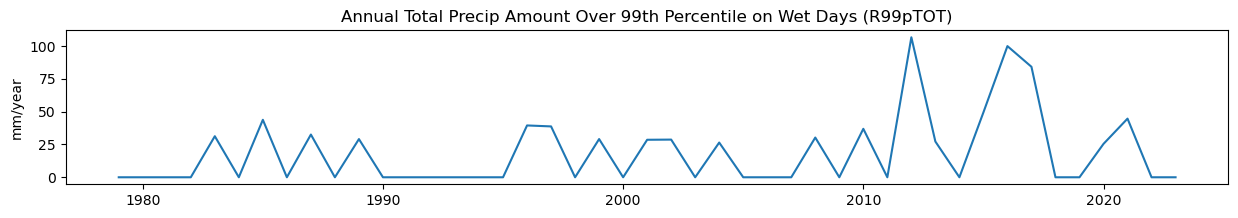

In [250]:
# plot
fig=plt.figure(figsize=(15,2))
plt.plot(R99pTOT.time_level_0,R99pTOT)
plt.title('Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)')
plt.ylabel('mm/year')
plt.show()

### Are the Changes In Value of These Indices Over Time Statistically Significant?

### Computing Climate Change Indices on Gridded Data

In [ ]:
# download/unzip data

In [ ]:
# repeat one of the above analysis

In [ ]:
# visualize

# Your Turn!

### Choose one of three coding mini-projects below to complete on your own and prepare to share your findings


**Option 1 (easiest):** Calculate the monthly mean daily temperature range (DTR) at the xx station a create a figure showing the DTR timeseries. 

&emsp;Hints:
- Use daily tmax and tmin data
- Calculate the daily temperature range as tmax-tmin
- For each month, find the mean of the range values you calculated in the previous step
- Plot your timeseries of monthly values. Include axis labels and a title. 

<br>
<br>

**Option 2 (moderate):** Calculate the cold spell duration index (CDSI) at the xx station and create a figure showing the CDSI timeseries. Extra: see if you can determine whether the change in the CDSI is statistically significant.

&emsp;Hints:
- Use daily tmin data
- Find the daily 10th percentile temperature using a centered 5-day window over the base period 1961-1990
- Using all data years, determine if each day exceeds the threshold (looking for days with tmin < threshold)
- Identify cold spells as periods of 6 consecutive days when the temperature exceeds the threshold
- Count how many total cold spell days there are annually (remember each cold spell is assigned to the year when the spell ends)
- Plot the timeseries of annual values. Include axis labels and a title.
- Extra Step: Determine statistical significance of the trend line (linear regression) or the difference in means between two 30-year periods (1941-1970) and (1991-2020).

<br>
<br>


**Option 3 (hardest):** Use a gridded dataset to compute the annual growing season length (GSL) at each grid cell. Then, calculate the trend in GSL at each grid cell and also determine whether each trend is statisically significant. Present your results in a figure that shows the GSL trend for each grid cell (on a map) and include an indication of whether each grid cell value is statistically significant.

&emsp;Hints:
- Use gridded daily tmax and tmin data
- Calculate daily mean temperature
- Use the same process we showed previously to determine the annual start/end of the growing season and find the annual GSL, except this time do the calculations at each grid cell.
- Calculate the trend (linear regression) in annual GSL at each grid cell.
- Determine if each trend is statistically significant.
- Plot the the map of trend values and indicate significance at each grid with hatching or some other visual indicator. Include a title and legend.



In [ ]:
# peek at the answer figure for option 1

In [ ]:
# peek at the answer figure for option 2

In [ ]:
# peek at the answer figure for option 3

Don't forget to create answer codes for these and put them in the repo. Direct learners to answers after the work-on-your-own session.